<a href="https://colab.research.google.com/github/indremontvilaite/training-neural-networks-in-python-3215347/blob/main/CNN_med.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data scientist | Ligence

## Technical interview
### Task description
Your task is to train and export a neural network for medical data classification. Create a python script or jupyter notebook with the code that executes training and validation, inference, and calculates required metrics and reaches goals outlined below. Export the code, the model file(s) and share it with us for assessment. We prefer that you use pytorch for the task because we are the most familiar with it, but feel free to choose tooling that you know.

In [13]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Data x-ray:
https://data.mendeley.com/datasets/rscbjbr9sj/2

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import h5py
# import SimpleITK as sitk
import pandas as pd
import matplotlib as mat
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from dataclasses import dataclass, fields
import glob
import cv2
import random
import scipy.misc
%matplotlib inline

pd.options.display.max_colwidth = 100
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from keras.utils import to_categorical
from tensorflow.random import set_seed
from tensorflow.keras.regularizers import l1


### Preprocesing of data

#### Constants and functions

In [2]:
class Config:
  IMG_SIZE:int = 224
  BATCH_SIZE:int = 34
  SEED:int = 42
  STEPS_PER_EPOCH:int = 36 #len(train_df)/Config.BATCH_SIZE
  EPOCHS:int = 20
  PATH:str = "/content/drive/MyDrive/Ligence"

@dataclass
class Labels:
  TWO_CH:str = 0
  FOUR_CH:str = 1
  PNEUMONIA:str = 2


In [3]:
def resize_image(image, image_size):

  img = cv2.imread(image)
  img = cv2.resize(img, (image_size, image_size))
  # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  return img

In [4]:
def get_pretrained(model):
    inputs = layers.Input(shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))

    x = model(inputs)
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    # x = model.output
    # x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(3, activation='softmax')(x)

    model = Model(inputs=[inputs], outputs=predictions)

    return model

In [5]:
def get_pretrained_l1(model, l1_n:float, dropout_n:float):
    inputs = layers.Input(shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))

    x = model(inputs)
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_n)(x)

    # x = model.output
    # x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(3, activation='softmax', kernel_regularizer=l1(l1_n))(x)

    model = Model(inputs=[inputs], outputs=predictions)

    return model

In [6]:
def get_pretrained_l2(model, l1_n:float, dropout_n:float):
    inputs = layers.Input(shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3))

    x = model(inputs)
    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer='l2')(x)
    x = layers.Dropout(dropout_n)(x)

    # x = model.output
    # x = layers.GlobalAveragePooling2D()(x)
    # x = layers.Dense(256, activation='relu')(x)
    predictions = layers.Dense(3, activation='softmax', kernel_regularizer=l1(l1_n))(x)

    model = Model(inputs=[inputs], outputs=predictions)

    return model

In [7]:
def loss_plot(history_df:pd.DataFrame, metric:str, val_metric:str):
  """ Plot accuracy and val_accuracy """
  plt.figure(figsize=(15,5))

  # plotting accuracy and val_accuracy
  plt.subplot(1,2,1)
  plt.plot(history_df[metric],label=metric,c='red')
  plt.plot(history_df[val_metric],label=val_metric)
  plt.xlabel('epochs')
  plt.ylabel('acc value')
  plt.title(f'{metric} VS {val_metric}')
  plt.legend()
  # plotting loss and val_loss
  plt.subplot(1,2,2)
  plt.plot(history_df['loss'],label='loss',c='red')
  plt.plot(history_df['val_loss'],label='val_loss')
  plt.title('loss VS val_loss')
  plt.xlabel('epochs')
  plt.ylabel('loss value')
  plt.legend()

  plt.show()

In [8]:
def get_predictions_metric(model, Labels, testing_images:np.array, test_y:pd.Series):

  prediction=model.predict(testing_images)
  prediction=np.argmax(prediction,axis=1)
  label_dict = {getattr(Labels, attr): attr for attr in dir(Labels) if not attr.startswith('__')}
  _prediction = [label_dict[k] for k in prediction]
  y_true = [label_dict[k] for k in test_y.values]

  report = classification_report(y_true,_prediction)

  return report, _prediction

#### Data preprocesing

- Explain your data distribution, is it balanced? Does it raise any issues, how do you address them?

 Dataset is balanced for 2ch and 4ch frames, 450 observations in each class. Having that, I have added 380 ChestXray pictures to have the data balanced.

 The difference comes from the color channels and image sizes. 2ch and 4ch are 1 color channel and Xrays are 3 color channels. Images were converted to 3D arrays since model architechtures even disigned for greyscale images like VGG16 was requiring 3D arrays. Images were resized to required size for modelling.

In [14]:
tf.random.set_seed(Config.SEED)

In [15]:
f = h5py.File("/content/drive/MyDrive/Ligence/subject_based_dataset.hdf5", "r")

In [16]:
train_data_2ch = f['train 2ch ED frames']

In [17]:
train_data_4ch = f['train 4ch ED frames']

In [18]:
main_path = "/content/drive/MyDrive/Ligence/chest_xray"

test_path=os.path.join(main_path,"test")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")

In [19]:
new_shape = (Config.IMG_SIZE, Config.IMG_SIZE)

In [20]:
df_2ch =  pd.DataFrame(np.concatenate([[Labels.TWO_CH]*len(train_data_2ch)]), columns = ['class'])
df_2ch['image'] = [cv2.resize(np.squeeze(np.stack((i, i, i), axis=-1), axis=2), new_shape) for i in train_data_2ch]


In [21]:
df_4ch =  pd.DataFrame(np.concatenate([[Labels.FOUR_CH]*len(train_data_4ch)]), columns = ['class'])
df_4ch['image'] = [cv2.resize(np.squeeze(np.stack((i, i, i), axis=-1), axis=2), new_shape) for i in train_data_4ch]

In [22]:
df_xcest =  pd.DataFrame(np.concatenate([[Labels.PNEUMONIA]*len(test_pneumonia)]), columns = ['class'])

In [23]:
df_xcest['image'] = [resize_image(i, Config.IMG_SIZE) for i in test_pneumonia]

In [24]:
df_combined = pd.concat([df_2ch, df_4ch, df_xcest], ignore_index=True)
df_combined.to_csv('/content/drive/MyDrive/Ligence/df_combined.csv', index=False)

In [25]:
train_df, test_df = train_test_split(df_combined, test_size = 0.05, random_state = Config.SEED, stratify = df_combined['class'])

In [26]:
# test_df.to_csv('/content/drive/MyDrive/Ligence/test_df.csv', index=False)
# train_df.to_csv('/content/drive/MyDrive/Ligence/train_df.csv', index=False)

In [27]:
# train_df2, val_df = train_test_split(train_df, test_size = 0.15, random_state = Config.SEED, stratify = train_df['class'])

In [28]:
# train_df = pd.read_csv('/content/drive/MyDrive/Ligence/train_df.csv')

In [29]:
train_df.head()

,class,image
1084,2,"[[[57, 57, 57], [79, 79, 79], [77, 77, 77], [77, 77, 77], [76, 76, 76], [74, 74, 74], [80, 80, 8..."
517,1,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0..."
1029,2,"[[[56, 56, 56], [55, 55, 55], [54, 54, 54], [59, 59, 59], [63, 63, 63], [255, 255, 255], [10, 10..."
1026,2,"[[[72, 72, 72], [127, 127, 127], [166, 166, 166], [170, 170, 170], [165, 165, 165], [169, 169, 1..."
213,0,"[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0..."


In [30]:
input = np.empty((len(train_df), Config.IMG_SIZE, Config.IMG_SIZE, 3))
train_df = train_df.reset_index()
for i in range(len(train_df)-1):
  try:
    image = train_df.loc[i, 'image']
    # input[i] = np.array([[str(elem).replace('\n', ',')] for elem in image.flatten()])
    input[i] = image
  except:
    print(i)


In [31]:
train_labels = to_categorical(np.array(train_df["class"]), num_classes=3)

#### Visualisations

In [ ]:
print(list(f.keys()))

['train 2ch ED frames', 'train 2ch ED masks', 'train 2ch ES frames', 'train 2ch ES masks', 'train 4ch ED frames', 'train 4ch ED masks', 'train 4ch ES frames', 'train 4ch ES masks']


In [ ]:
train_data_2ch.shape

(450, 384, 384, 1)

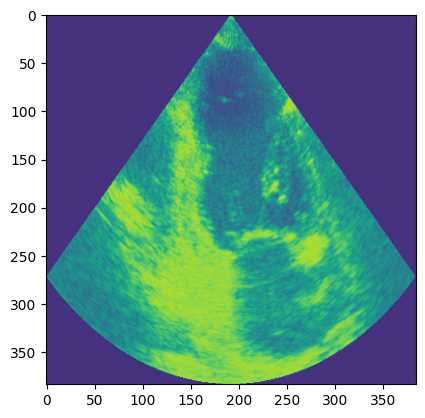

In [ ]:
plt.imshow(train_data_2ch[3,:,:,:])
plt.show()

In [ ]:
train_data_4ch.shape

(450, 384, 384, 1)

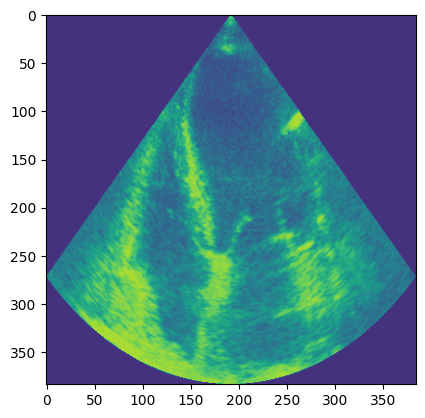

In [ ]:
plt.imshow(train_data_4ch[3,:,:,0])
plt.show()

In [ ]:
len(train_data_4ch)

450

In [ ]:
len(test_pneumonia)

390

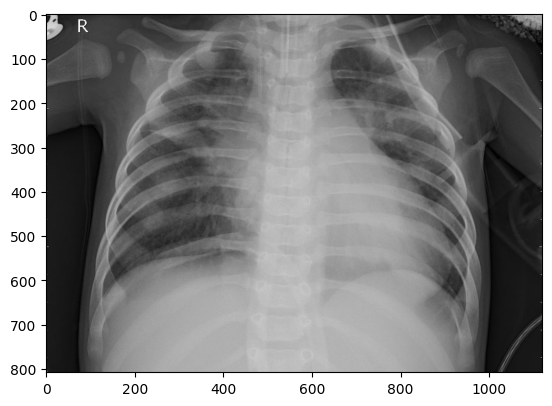

In [ ]:
img = cv2.imread(test_pneumonia[0])
# img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)

### Modelling

- Explain your model architecture choices. What are the alternatives?
  As a base model is was decided to use VGG16 which should work well on greyscale images classification and was state-of-art model some years ago. As a more advanced model it was dicided to use smaller version of NASNET model which is considered to be effective in terms of operations and accuracy.

  ![Image classification plot for Imagenet](https://theaisummer.com/static/4690fef2d8149b10c72af46aca0710be/c1b63/image-classification-plot-imagenet.png "State-of-the-art models by accuracy")

  - VGG16 model got poor results, validation accuracy - 0.68, and the model was underfitted. It was decide to move to next, more advanced model.
  - Nastet model performed well on training set, F1-score are ~0.96 per category. However, the model performed poorly on validation and test sets, the F1-score varied [0, 0.5] per category. The model was overfitted.
  - The stategy was to work with overfitting model since it should be easier to deal with ovenfitting than underfitting. The methods to reduse overfitting were applied:
    - Image augmentation. At the begining the data was preprocessed as per model training.
    - Fine tunning. Some models layers were unfreezed for training.
    - L1 and L2 regularisations.
    - Dropout.
  
    Unfortunately, none of the methods applied gave wanted results and the models performance not increased in any terms.

  - Latest state-of-the-art model, EfficientNetV2L, was not able to train due to computational resources limitations.

  - Alternative options could be:
    - to do image augmentation more specifically, based on domain knowledge.
    - to try FastAI models which ussually outperms others
    - to create CNN myself with keras.sequential()
  
  - Explain your decision on loss function

    Categorical crossentropy was chosen because it is most popular metric for classification task where number of categories are more than 2. Not have specific knowledge or experience, the popular metric was chosen.

  - Explain why and how you chose validation metrics.

    Validation metrics were chosen to reveale clasification per category and by the requiremnets from the task to estimate precision and F1 score.



#### Base model - VGG16

In [32]:
early_stopping=callbacks.EarlyStopping(monitor='val_loss',patience=3,verbose=1,restore_best_weights=True)
reduce_lr=callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2,verbose=0,factor=0.1)
# model_check_point=callbacks.ModelCheckpoint(monitor='val_accuracy',filepath='./bestmodel.h5',save_best_only=True,verbose=True)

In [60]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3)
    )

base_model.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [61]:
train_datagen = ImageDataGenerator(tf.keras.applications.vgg16.preprocess_input,
                                  rescale=1./255,
                                  validation_split=0.15,
)

ds_train = train_datagen.flow(
    x=input,
    y=train_labels,
    batch_size = Config.BATCH_SIZE,
    seed = Config.SEED,
    subset='training'
)

ds_val = train_datagen.flow(
    x=input,
    y=train_labels,
    batch_size = Config.BATCH_SIZE,
    seed = Config.SEED,
    subset='validation'
)

In [62]:
model = get_pretrained(base_model)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', keras.metrics.CategoricalAccuracy(), keras.metrics.Precision])

history=model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=3,
    batch_size=Config.BATCH_SIZE,
    callbacks=[early_stopping,reduce_lr]

)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 856s 28s/step - accuracy: 0.5217 - categorical_accuracy: 0.5217 - loss: 0.9089 - precision_1: 0.6330 - val_accuracy: 0.6612 - val_categorical_accuracy: 0.6612 - val_loss: 0.5353 - val_precision_1: 0.6612 - learning_rate: 0.0010
Epoch 2/3
31/31 ━━━━━━━━━━━━━━━━━━━━ 820s 26s/step - accuracy: 0.6936 - categorical_accuracy: 0.6936 - loss: 0.5283 - precision_1: 0.6994 - val_accuracy: 0.6612 - val_categorical_accuracy: 0.6612 - val_loss: 0.4762 - val_precision_1: 0.6612 - learning_rate: 0.0010
Epoch 3/3
31/31 ━━━━━━━━━━━━━━━━━━━━ 867s 27s/step - accuracy: 0.6710 - categorical_accuracy: 0.6710 - loss: 0.5091 - precision_1: 0.6758 - val_accuracy: 0.6831 - val_categorical_accuracy: 0.6831 - val_loss: 0.4646 - val_precision_1: 0.6831 - learning_rate: 0.0010
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [63]:
history_df=pd.DataFrame(history.history)
history_df

,accuracy,categorical_accuracy,loss,precision_1,val_accuracy,val_categorical_accuracy,val_loss,val_precision_1,learning_rate
0,0.596929,0.596929,0.750276,0.691339,0.661202,0.661202,0.535326,0.661202,0.001
1,0.663148,0.663148,0.538156,0.666336,0.661202,0.661202,0.476226,0.661202,0.001
2,0.676583,0.676583,0.500416,0.678501,0.683060,0.683060,0.464631,0.683060,0.001


In [ ]:
# VGG16
# accuracy	loss	val_accuracy	val_loss	learning_rate
# 0	0.605566	0.698123	0.661202	0.486848	0.001
# 1	0.644914	0.515068	0.683060	0.463929	0.001
# 2	0.640115	0.517256	0.683060	0.496682	0.001


#### State of Art model - Nasnet

In [33]:
nasnet_model = tf.keras.applications.NASNetMobile(
    weights='imagenet',
    include_top=False,
    input_shape=(Config.IMG_SIZE, Config.IMG_SIZE, 3),
    )

model_nasnet = get_pretrained(nasnet_model)
model_nasnet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', keras.metrics.CategoricalAccuracy(), keras.metrics.Precision(), keras.metrics.F1Score()])

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [34]:
train_nasnet = ImageDataGenerator(tf.keras.applications.nasnet.preprocess_input,
                                  rescale=1./255,
                                  validation_split=0.15,
)

ds_train_nasnet = train_nasnet.flow(
    x=input,
    y=train_labels,
    batch_size = Config.BATCH_SIZE,
    seed = Config.SEED,
    subset='training'
)

ds_val_nasnet = train_nasnet.flow(
    x=input,
    y=train_labels,
    batch_size = Config.BATCH_SIZE,
    seed = Config.SEED,
    subset='validation'
)

In [35]:
input_test = np.empty((len(test_df), Config.IMG_SIZE, Config.IMG_SIZE, 3))
test_df = test_df.reset_index()
for i in range(len(test_df)-1):
  try:
    image = test_df.loc[i, 'image']
    input_test[i] = image
  except:
    print(i)

test_labels = to_categorical(np.array(test_df["class"]), num_classes=4)
train_nasnet = ImageDataGenerator(tf.keras.applications.nasnet.preprocess_input,
                                  rescale=1./255,
                                  validation_split=0.15,
)

testing_images = train_nasnet.flow(
    x=input_test,
    y=test_labels,
    batch_size = Config.BATCH_SIZE,
    seed = Config.SEED
)

In [36]:
history_nasnet=model_nasnet.fit(
    ds_train_nasnet,
    validation_data=ds_val_nasnet,
    epochs=7,
    batch_size=Config.BATCH_SIZE,
    callbacks=[early_stopping,reduce_lr]

)

Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 522s 11s/step - accuracy: 0.6069 - categorical_accuracy: 0.6069 - f1_score: 0.6179 - loss: 0.6630 - precision: 0.6287 - val_accuracy: 0.3443 - val_categorical_accuracy: 0.3443 - val_f1_score: 0.1707 - val_loss: 5.7226 - val_precision: 0.3443 - learning_rate: 0.0010
Epoch 2/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 371s 11s/step - accuracy: 0.9084 - categorical_accuracy: 0.9084 - f1_score: 0.9137 - loss: 0.2268 - precision: 0.9097 - val_accuracy: 0.3443 - val_categorical_accuracy: 0.3443 - val_f1_score: 0.1707 - val_loss: 22.3673 - val_precision: 0.3443 - learning_rate: 0.0010
Epoch 3/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 413s 12s/step - accuracy: 0.9587 - categorical_accuracy: 0.9587 - f1_score: 0.9611 - loss: 0.1320 - precision: 0.9587 - val_accuracy: 0.3279 - val_categorical_accuracy: 0.3279 - val_f1_score: 0.1646 - val_loss: 15.3175 - val_precision: 0.3279 - learning_rate: 0.0010
Epoch 4/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 341s 11s/step - accuracy: 0.9724 - categorical_accuracy: 0.972

In [27]:
model_nasnet.save(f"{Config.PATH}.keras")

In [28]:
history_nasnet_df = pd.DataFrame(history_nasnet.history)

In [29]:
history_nasnet_df.tail()

,accuracy,categorical_accuracy,f1_score,loss,precision,val_accuracy,val_categorical_accuracy,val_f1_score,val_loss,val_precision,learning_rate
0,0.820537,0.820537,"(tf.Tensor(0.76455027, shape=(), dtype=float32), tf.Tensor(0.74509794, shape=(), dtype=float32),...",0.398265,0.845766,0.344262,0.344262,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.Tensor(0.0, shape=(), dtype=float32), tf.Tensor(0.5...",7.368696,0.344262,0.0010
1,0.925144,0.925144,"(tf.Tensor(0.8945946, shape=(), dtype=float32), tf.Tensor(0.892857, shape=(), dtype=float32), tf...",0.189245,0.925144,0.344262,0.344262,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.Tensor(0.0, shape=(), dtype=float32), tf.Tensor(0.5...",8.886910,0.344262,0.0010
2,0.973129,0.973129,"(tf.Tensor(0.96164376, shape=(), dtype=float32), tf.Tensor(0.96205956, shape=(), dtype=float32),...",0.083523,0.973129,0.344262,0.344262,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.Tensor(0.0, shape=(), dtype=float32), tf.Tensor(0.5...",8.422289,0.344262,0.0010
3,0.962572,0.962572,"(tf.Tensor(0.9469387, shape=(), dtype=float32), tf.Tensor(0.9467939, shape=(), dtype=float32), t...",0.109089,0.962572,0.344262,0.344262,"(tf.Tensor(0.0, shape=(), dtype=float32), tf.Tensor(0.0, shape=(), dtype=float32), tf.Tensor(0.5...",10.882584,0.344262,0.0001


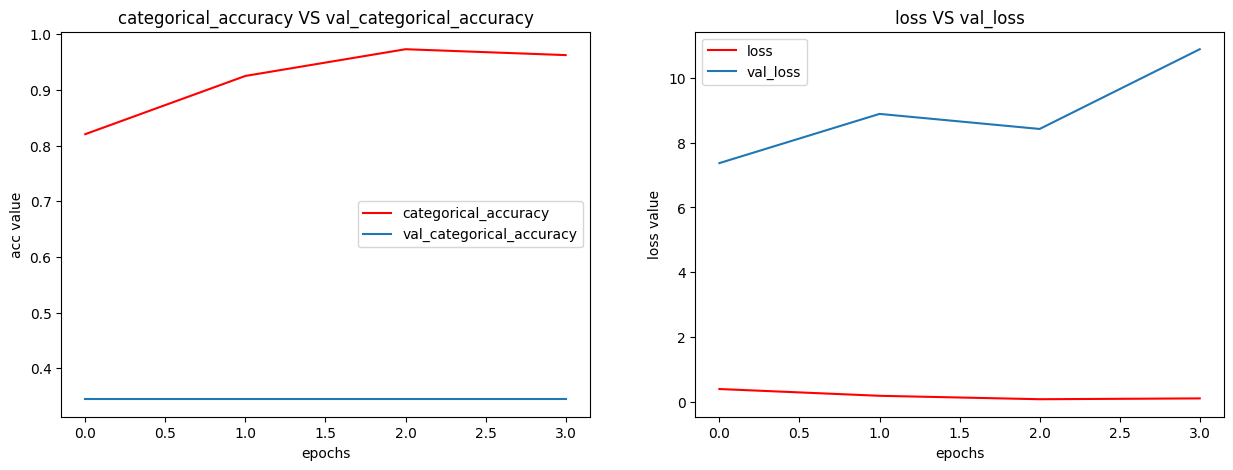

In [30]:
loss_plot(history_nasnet_df, "categorical_accuracy", "val_categorical_accuracy")

In [31]:
metrics_nasnet, prediction_nasnet = get_predictions_metric(model_nasnet, Labels, testing_images, test_df['class'])
print(metrics_nasnet)

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 9s/step
              precision    recall  f1-score   support

     FOUR_CH       0.00      0.00      0.00        23
   PNEUMONIA       0.29      1.00      0.45        19
      TWO_CH       0.00      0.00      0.00        23

    accuracy                           0.29        65
   macro avg       0.10      0.33      0.15        65
weighted avg       0.09      0.29      0.13        65



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Image augmentation

In [ ]:
train_nasnet2 = ImageDataGenerator(tf.keras.applications.nasnet.preprocess_input,
                                  rescale=1./255,
                                  validation_split=0.15,
                                   rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  vertical_flip=True,
)

ds_train_nasnet = train_nasnet2.flow(
    x=input,
    y=train_labels,
    batch_size = Config.BATCH_SIZE,
    seed = Config.SEED,
    subset='training'
)

ds_val_nasnet = train_nasnet2.flow(
    x=input,
    y=train_labels,
    batch_size = Config.BATCH_SIZE,
    seed = Config.SEED,
    subset='validation'
)


In [ ]:
history_nasnet2=model_nasnet.fit(
    ds_train_nasnet,
    validation_data=ds_val_nasnet,
    epochs=7,
    batch_size=Config.BATCH_SIZE,
    callbacks=[early_stopping,reduce_lr]

)

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/7


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 577s 13s/step - accuracy: 0.6312 - categorical_accuracy: 0.6312 - f1_score: 0.4751 - loss: 0.7253 - precision: 0.6680 - val_accuracy: 0.6175 - val_categorical_accuracy: 0.6175 - val_f1_score: 0.3960 - val_loss: 0.9115 - val_precision: 0.8730 - learning_rate: 0.0010
Epoch 2/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 426s 13s/step - accuracy: 0.8130 - categorical_accuracy: 0.8130 - f1_score: 0.6175 - loss: 0.3807 - precision: 0.8130 - val_accuracy: 0.3279 - val_categorical_accuracy: 0.3279 - val_f1_score: 0.1765 - val_loss: 2.3393 - val_precision: 0.3279 - learning_rate: 0.0010
Epoch 3/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 391s 13s/step - accuracy: 0.8749 - categorical_accuracy: 0.8749 - f1_score: 0.6617 - loss: 0.3312 - precision: 0.8762 - val_accuracy: 0.3443 - val_categorical_accuracy: 0.3443 - val_f1_score: 0.1280 - val_loss: 2.7662 - val_precision: 0.3443 - learning_rate: 0.0010
Epoch 4/7
31/31 ━━━━━━━━━━━━━━━━━━━━ 388s 12s/step - accuracy: 0.8952 - categorical_accuracy: 0.8952 

In [ ]:
prediction_nasnet2=model_nasnet.predict(testing_images)
prediction_nasnet2=np.argmax(prediction_nasnet2,axis=1)

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 26s 14s/step


In [ ]:
label_dict = {getattr(Labels, attr): attr for attr in dir(Labels) if not attr.startswith('__')}
prediction_nasnet2_ = [label_dict[k] for k in prediction_nasnet2]
y_true = [label_dict[k] for k in test_df['class'].values]

print(classification_report(y_true,prediction_nasnet2_))

              precision    recall  f1-score   support

     FOUR_CH       0.00      0.00      0.00        23
   PNEUMONIA       0.26      0.26      0.26        19
      TWO_CH       0.30      0.61      0.41        23

    accuracy                           0.29        65
   macro avg       0.19      0.29      0.22        65
weighted avg       0.18      0.29      0.22        65



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Fine tunning

In [64]:
keras.backend.clear_session()
nasnet_model.trainable = True

# Freeze all layers except for the
for layer in nasnet_model.layers[:-20]:
    layer.trainable = False

model_finetune=get_pretrained(nasnet_model)
model_finetune.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', keras.metrics.CategoricalAccuracy(), keras.metrics.Precision(), keras.metrics.F1Score()])

In [65]:
history_finetune=model_finetune.fit(
    ds_train_nasnet,
    validation_data=ds_val_nasnet,
    epochs=100,
    batch_size=Config.BATCH_SIZE,
    callbacks=[early_stopping,reduce_lr]

)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 154s 4s/step - accuracy: 0.5662 - categorical_accuracy: 0.5662 - f1_score: 0.5564 - loss: 0.6385 - precision: 0.6628 - val_accuracy: 0.6831 - val_categorical_accuracy: 0.6831 - val_f1_score: 0.5604 - val_loss: 0.4645 - val_precision: 0.6831 - learning_rate: 0.0010
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.6425 - categorical_accuracy: 0.6425 - f1_score: 0.6564 - loss: 0.5063 - precision: 0.6414 - val_accuracy: 0.6831 - val_categorical_accuracy: 0.6831 - val_f1_score: 0.5604 - val_loss: 0.4843 - val_precision: 0.6831 - learning_rate: 0.0010
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.6488 - categorical_accuracy: 0.6488 - f1_score: 0.6544 - loss: 0.5085 - precision: 0.6491 - val_accuracy: 0.6831 - val_categorical_accuracy: 0.6831 - val_f1_score: 0.5604 - val_loss: 0.4748 - val_precision: 0.6831 - learning_rate: 0.0010
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


In [54]:
report_finetune, prediction_finetune = get_predictions_metric(model_finetune, Labels, testing_images, test_df['class'])
print(report_finetune)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step
              precision    recall  f1-score   support

     FOUR_CH       0.33      0.65      0.44        23
   PNEUMONIA       0.26      0.26      0.26        19
      TWO_CH       0.00      0.00      0.00        23

    accuracy                           0.31        65
   macro avg       0.20      0.31      0.23        65
weighted avg       0.19      0.31      0.23        65



In [55]:
model_finetune.save(f'{Config.PATH}model_finetune.keras')

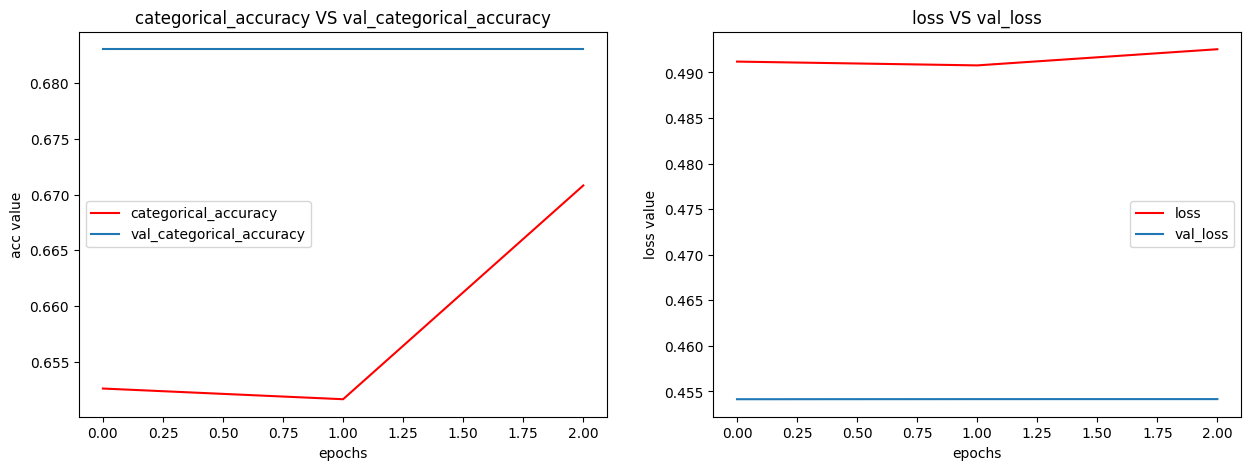

In [56]:
history_finetune_df = history_finetune.history
loss_plot(history_finetune_df, "categorical_accuracy", "val_categorical_accuracy")

### Hyperparameters tunning to reduce overfitting
 - L1 regularisation
 - Increase Dropout




In [37]:
keras.backend.clear_session()
nasnet_model.trainable = False

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=Config.STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

model_l1=get_pretrained_l1(nasnet_model, l1_n=0.001, dropout_n=0.2)
model_l1.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy', keras.metrics.CategoricalAccuracy(), keras.metrics.Precision(), keras.metrics.F1Score()])

In [38]:
history_l1=model_l1.fit(
    ds_train_nasnet,
    validation_data=ds_val_nasnet,
    epochs=10,
    batch_size=Config.BATCH_SIZE,
    callbacks=[early_stopping,reduce_lr]

)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.6000 - categorical_accuracy: 0.6000 - f1_score: 0.6162 - loss: 0.8165 - precision: 0.6024 - val_accuracy: 0.6612 - val_categorical_accuracy: 0.6612 - val_f1_score: 0.5506 - val_loss: 0.5107 - val_precision: 0.6612 - learning_rate: 0.0010
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.6458 - categorical_accuracy: 0.6458 - f1_score: 0.6651 - loss: 0.5647 - precision: 0.6453 - val_accuracy: 0.6831 - val_categorical_accuracy: 0.6831 - val_f1_score: 0.5604 - val_loss: 0.5421 - val_precision: 0.6831 - learning_rate: 0.0010
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 88s 3s/step - accuracy: 0.6613 - categorical_accuracy: 0.6613 - f1_score: 0.6684 - loss: 0.5391 - precision: 0.6644 - val_accuracy: 0.6831 - val_categorical_accuracy: 0.6831 - val_f1_score: 0.5604 - val_loss: 0.4864 - val_precision: 0.6831 - learning_rate: 0.0010
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 96s 3s/step - accuracy: 0.6547 - categorical_accuracy:

In [39]:
report_l1, prediction_l1= get_predictions_metric(model_l1, Labels, testing_images, test_df['class'])
print(report_l1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 8s/step
              precision    recall  f1-score   support

     FOUR_CH       0.39      0.78      0.52        23
   PNEUMONIA       0.26      0.26      0.26        19
      TWO_CH       0.00      0.00      0.00        23

    accuracy                           0.35        65
   macro avg       0.22      0.35      0.26        65
weighted avg       0.22      0.35      0.26        65



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [43]:
model_l1.save(f'{Config.PATH}model_fl1.keras')

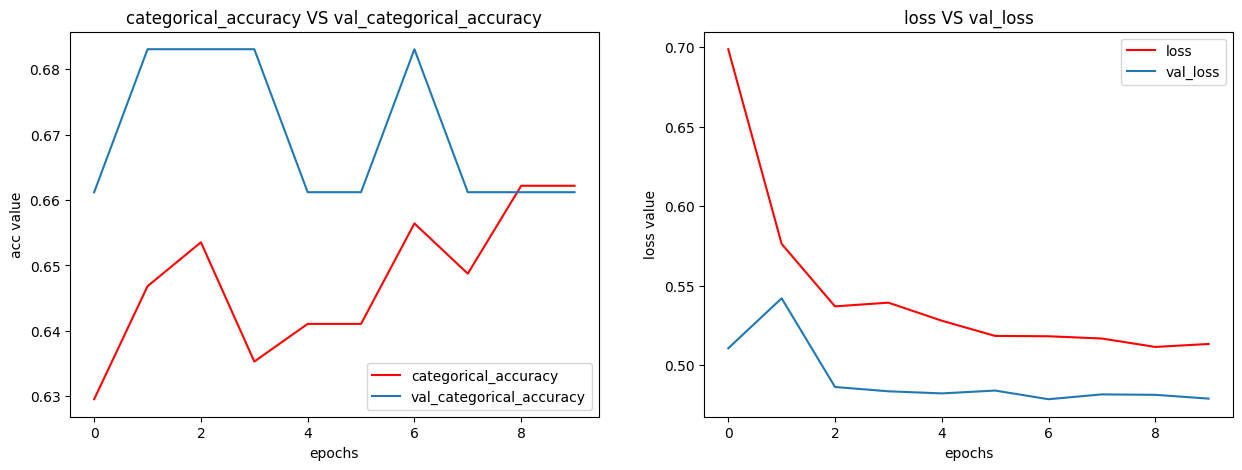

In [40]:
history_l1_df = history_l1.history
loss_plot(history_l1_df, "categorical_accuracy", "val_categorical_accuracy")

### Fine tune with hyprparameters

In [51]:
keras.backend.clear_session()
nasnet_model.trainable = True

# Freeze all layers except for the
for layer in nasnet_model.layers[:-10]:
    layer.trainable = False

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=Config.STEPS_PER_EPOCH*10000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

model_l1_v2=get_pretrained_l2(nasnet_model, l1_n=0.005, dropout_n=0.2)
model_l1_v2.compile(optimizer=get_optimizer(),
              loss='categorical_crossentropy',
              metrics=['accuracy', keras.metrics.CategoricalAccuracy(), keras.metrics.Precision(), keras.metrics.F1Score()])

In [52]:
history_l2=model_l1_v2.fit(
    ds_train_nasnet,
    validation_data=ds_val_nasnet,
    epochs=10,
    batch_size=Config.BATCH_SIZE,
    callbacks=[early_stopping,reduce_lr]

)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


31/31 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.2883 - categorical_accuracy: 0.2883 - f1_score: 0.2765 - loss: 3.1248 - precision: 0.2442 - val_accuracy: 0.3169 - val_categorical_accuracy: 0.3169 - val_f1_score: 0.1604 - val_loss: 1.9848 - val_precision: 0.0000e+00 - learning_rate: 9.9991e-04
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.3338 - categorical_accuracy: 0.3338 - f1_score: 0.2726 - loss: 1.8197 - precision: 0.0000e+00 - val_accuracy: 0.3443 - val_categorical_accuracy: 0.3443 - val_f1_score: 0.1707 - val_loss: 1.4911 - val_precision: 0.0000e+00 - learning_rate: 9.9983e-04
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.3214 - categorical_accuracy: 0.3214 - f1_score: 0.2775 - loss: 1.4482 - precision: 0.0000e+00 - val_accuracy: 0.3169 - val_categorical_accuracy: 0.3169 - val_f1_score: 0.1604 - val_loss: 1.3573 - val_precision: 0.0000e+00 - learning_rate: 9.9974e-04
Epoch 3: early stopping
Restoring model weights from the end of the be

In [53]:
report_l2, prediction_l2= get_predictions_metric(model_l1_v2, Labels, testing_images, test_df['class'])
print(report_l2)

1/2 ━━━━━━━━━━━━━━━━━━━━ 8s 9s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step
              precision    recall  f1-score   support

     FOUR_CH       0.00      0.00      0.00        23
   PNEUMONIA       0.00      0.00      0.00        19
      TWO_CH       0.35      0.96      0.51        23

    accuracy                           0.34        65
   macro avg       0.12      0.32      0.17        65
weighted avg       0.12      0.34      0.18        65



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


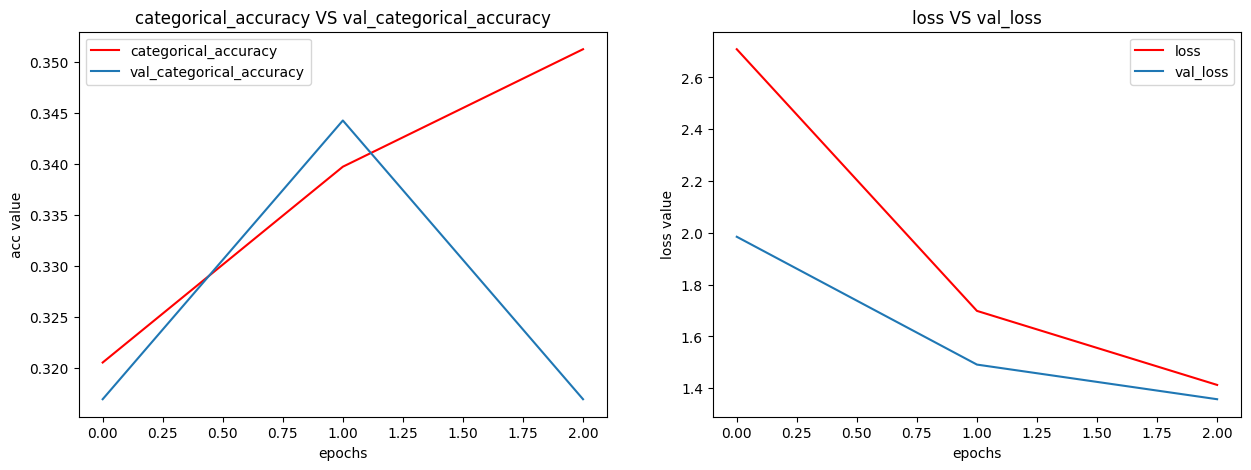

In [54]:
history_l2_df = history_l2.history
loss_plot(history_l2_df, "categorical_accuracy", "val_categorical_accuracy")

### Efficient net L2

In [29]:
efficient_model = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation='softmax',
    include_preprocessing=True
)

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 22s 0us/step


In [30]:
train_datagen_v2 = ImageDataGenerator(tf.keras.applications.efficientnet_v2.preprocess_input,
                                  rescale=1./255,
                                  validation_split=0.15,
)

ds_train_eff_v2 =train_datagen_v2.flow(
    x=input,
    y=train_labels,
    batch_size = Config.BATCH_SIZE,
    seed = Config.SEED,
    subset='training'
)

ds_val_eff_v2 = train_datagen_v2.flow(
    x=input,
    y=train_labels,
    batch_size = Config.BATCH_SIZE,
    seed = Config.SEED,
    subset='validation'
)

input_test = np.empty((len(test_df), Config.IMG_SIZE, Config.IMG_SIZE, 3))
test_df = test_df.reset_index()
for i in range(len(test_df)-1):
  try:
    image = test_df.loc[i, 'image']
    input_test[i] = image
  except:
    print(i)

test_labels = to_categorical(np.array(test_df["class"]), num_classes=4)

testing_images_eff_v2 = train_datagen_v2.flow(
    x=input_test,
    y=test_labels,
    batch_size = Config.BATCH_SIZE,
    seed = Config.SEED
)

model_eff_v2=get_pretrained(efficient_model)
model_eff_v2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', keras.metrics.CategoricalAccuracy(), keras.metrics.Precision(), keras.metrics.F1Score()])

In [ ]:
history_eff_v2=model_eff_v2.fit(
    ds_train_eff_v2,
    validation_data=ds_val_eff_v2,
    epochs=10,
    batch_size=Config.BATCH_SIZE,
    callbacks=[early_stopping,reduce_lr]

)

/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:1263: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6076 - categorical_accuracy: 0.6076 - f1_score: 0.6276 - loss: 0.7170 - precision: 0.6067

In [ ]:
report_eff_v2, prediction_eff_v2= get_predictions_metric(model_eff_v2, Labels, testing_images_eff_v2, test_df['class'])
print(report_eff_v2)

In [ ]:
history_eff_v2_df = history_eff_v2.history
loss_plot(history_eff_v2_df, "categorical_accuracy", "val_categorical_accuracy")